<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Trabajo de final de máster (TFM)</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Análisis predictivo de datos desbalanceados sobre el fraude en transacciones basadas en el uso de tarjetas de crédito


## Autor: Yago Ezcurra González.

# Introducción/ Contexto

Mundialmente las pérdidas financieras causadas por fraude en transacciones con tarjetas de crédito alcanzaron los 28.58 billones de dólares en todo el mundo en 2020, según los datos más recientes del [Informe Nilson](https://nilsonreport.com/upload/content_promo/NilsonReport_Issue1209.pdf).

En este notebook desarrollaremos algunos modelos de ML utilizando datos de transacciones de tarjetas de crédito anonimizadas procedientes de [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). El conjunto de datos contiene transacciones realizadas por tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeas. Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de 284,807 transacciones. El conjunto de datos es altamente desequilibrado, la clase positiva (fraudes) representa el 0,172% de todas las transacciones


# Preparación de los datos

## **Inicialización y carga del conjunto de datos**

En primer lugar, se importan todas las librerias necesarias para la correcta ejecucion de nuestro proyecto.

In [39]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import time
import pickle


# Classifier Libraries
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score, det_curve, classification_report,  confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore') #specify to ignore warning messages

A continuación, se carga el conjunto de datos Credit Card Fraud Detection de Kaggle (más información en el enlace https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

In [40]:
# lectura del fichero creditcard.csv
df = pd.read_csv('input/creditcard.csv')

# Obtenemos el número de filas y de columnas del conjunto de datos
print("Número de filas:", df.shape[0], "y número de columnas:", df.shape[1])

# Obtenemos los datos de las 5 primeras filas
df.head(5)

Número de filas: 284807 y número de columnas: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Obtenemos la información sobre nuestro conjunto de datos, incluidos el dtype de índice y las columnas, los valores no nulos y el uso de memoria.

In [41]:
# Obtenemos la información del conjutno de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [42]:
# Comprobamos si hay valores nulos
df.isnull().values.any()

False

Observamos que no hay valores nulos, y que todos los atributos son valores cuantitativos.

In [43]:
# Obtenemos estadísticas descriptivas del conjunto de datos
summary = df.describe()
summary.transpose()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


## **Limpieza de los datos**

### **Valores duplicados**

Una vez revisado que no haya valores nulos, revisamos si hay valores duplicados y en el caso que haya se eliminan.

In [44]:
print(df.shape)
df.drop_duplicates(keep='first', inplace=True)
print(df.shape)

(284807, 31)
(283726, 31)


### **Valores atípicos**

Los valores atípicos son valores numéricamente distantes del resto de los datos. Estos valores, pueden ser valores reales o errores y una forma de visualizarlos es mediante el uso de un diagramas de caja.

Text(0.5, 1.0, 'Diagrama de caja de Amount')

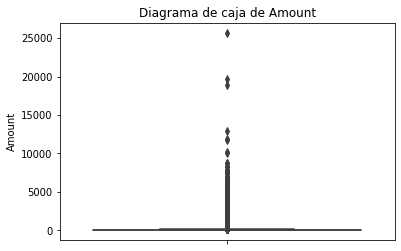

In [45]:
sns.boxplot( y="Amount", data=df)
plt.title("Diagrama de caja de Amount")

Text(0.5, 1.0, 'Diagrama de caja de Time')

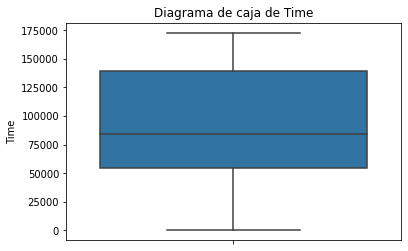

In [46]:
sns.boxplot( y="Time", data=df)
plt.title("Diagrama de caja de Time")

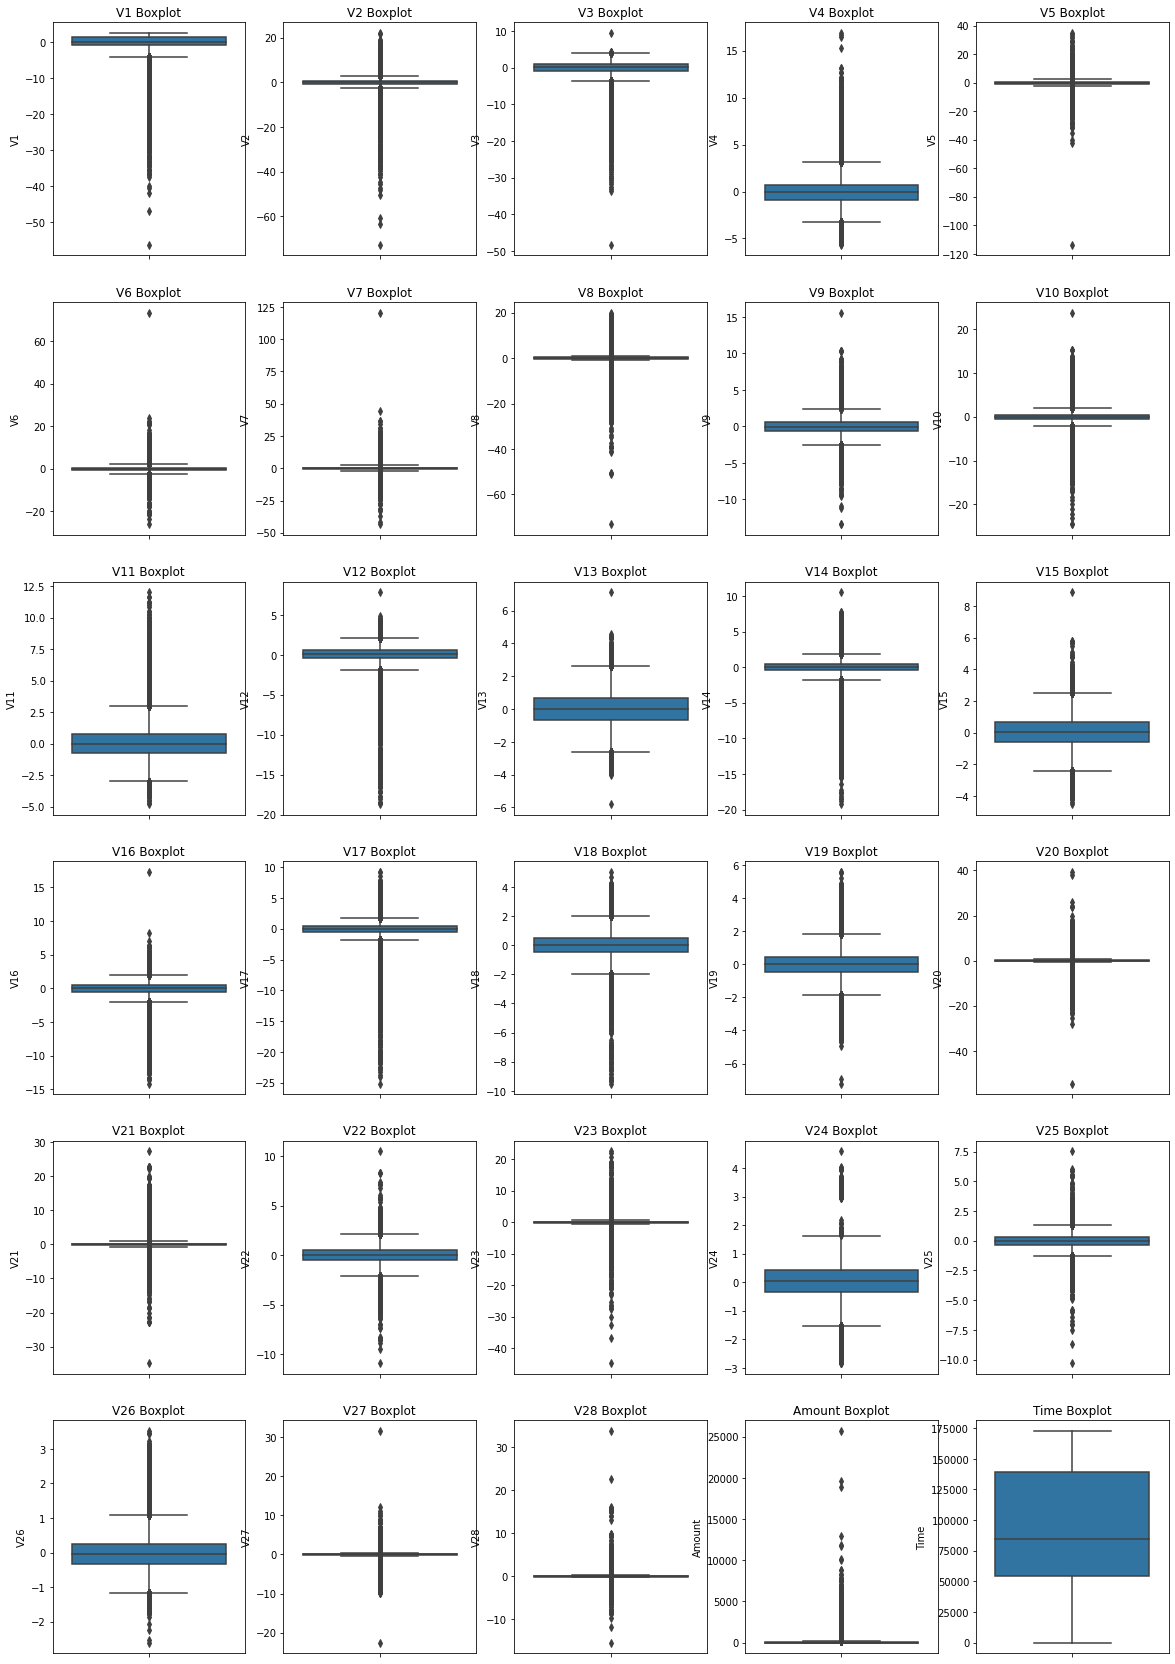

In [47]:
f, axes = plt.subplots(nrows=6, ncols=5, figsize=(20,30))


sns.boxplot( y="V1", data=df, ax=axes[0,0])
axes[0,0].set_title('V1 Boxplot')

sns.boxplot( y="V2", data=df, ax=axes[0,1])
axes[0,1].set_title('V2 Boxplot')

sns.boxplot( y="V3", data=df, ax=axes[0,2])
axes[0,2].set_title('V3 Boxplot')

sns.boxplot( y="V4", data=df, ax=axes[0,3])
axes[0,3].set_title('V4 Boxplot')

sns.boxplot( y="V5", data=df, ax=axes[0,4])
axes[0,4].set_title('V5 Boxplot')

sns.boxplot( y="V6", data=df, ax=axes[1,0])
axes[1,0].set_title('V6 Boxplot')

sns.boxplot( y="V7", data=df, ax=axes[1,1])
axes[1,1].set_title('V7 Boxplot')

sns.boxplot( y="V8", data=df, ax=axes[1,2])
axes[1,2].set_title('V8 Boxplot')

sns.boxplot( y="V9", data=df, ax=axes[1,3])
axes[1,3].set_title('V9 Boxplot')

sns.boxplot( y="V10", data=df, ax=axes[1,4])
axes[1,4].set_title('V10 Boxplot')

sns.boxplot( y="V11", data=df, ax=axes[2,0])
axes[2,0].set_title('V11 Boxplot')

sns.boxplot( y="V12", data=df, ax=axes[2,1])
axes[2,1].set_title('V12 Boxplot')

sns.boxplot( y="V13", data=df, ax=axes[2,2])
axes[2,2].set_title('V13 Boxplot')

sns.boxplot( y="V14", data=df, ax=axes[2,3])
axes[2,3].set_title('V14 Boxplot')

sns.boxplot( y="V15", data=df, ax=axes[2,4])
axes[2,4].set_title('V15 Boxplot')

sns.boxplot( y="V16", data=df, ax=axes[3,0])
axes[3,0].set_title('V16 Boxplot')

sns.boxplot( y="V17", data=df, ax=axes[3,1])
axes[3,1].set_title('V17 Boxplot')

sns.boxplot( y="V18", data=df, ax=axes[3,2])
axes[3,2].set_title('V18 Boxplot')

sns.boxplot( y="V19", data=df, ax=axes[3,3])
axes[3,3].set_title('V19 Boxplot')

sns.boxplot( y="V20", data=df, ax=axes[3,4])
axes[3,4].set_title('V20 Boxplot')

sns.boxplot( y="V21", data=df, ax=axes[4,0])
axes[4,0].set_title('V21 Boxplot')

sns.boxplot( y="V22", data=df, ax=axes[4,1])
axes[4,1].set_title('V22 Boxplot')

sns.boxplot( y="V23", data=df, ax=axes[4,2])
axes[4,2].set_title('V23 Boxplot')

sns.boxplot( y="V24", data=df, ax=axes[4,3])
axes[4,3].set_title('V24 Boxplot')

sns.boxplot( y="V25", data=df, ax=axes[4,4])
axes[4,4].set_title('V25 Boxplot')

sns.boxplot( y="V26", data=df, ax=axes[5,0])
axes[5,0].set_title('V26 Boxplot')

sns.boxplot( y="V27", data=df, ax=axes[5,1])
axes[5,1].set_title('V27 Boxplot')

sns.boxplot( y="V28", data=df, ax=axes[5,2])
axes[5,2].set_title('V28 Boxplot')

sns.boxplot( y="Amount", data=df, ax=axes[5,3])
axes[5,3].set_title('Amount Boxplot')

sns.boxplot( y="Time", data=df, ax=axes[5,4])
axes[5,4].set_title('Time Boxplot')

plt.show()

Como se pueden observar en los gráficos de barras, la mayoría de los atributos tienes cierta cantidad de valores atípicos. Pero al tratarse de un dataset resultante de una transformación PCA y se asume que los valores son reales, no se elimina ningún valor atípico.

## **Transformación de los datos**

La mayoria de atributos de este dataset vienen escalados. Por lo que escalaremos tambien los atributos Time y Amount aplicando el RobustScaler de sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html).

In [48]:
# Definimos el RobustScaler
scaler = RobustScaler()

# Creamos nuevas columnas con los valores escalados
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Eliminamos las columnas sin escalar
df.drop(['Time','Amount'], axis=1, inplace=True)

In [49]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.774718,-0.995290
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.268530,-0.995290
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.959811,-0.995279
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.411487,-0.995279
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.667362,-0.995267


In [50]:
# Exportamos el csv limpiado
df.to_csv('creditcard_clean.csv')

# Análisis exploratorio de los datos

Obtenemos las estadísticas descriptivas, que incluyen aquellas que resumen la tendencia central, la dispersión y la forma de la distribución de un conjunto de datos, excluyendo los valores de NaN.

In [14]:
# Obtenemos estadísticas descriptivas del conjunto de datos
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,...,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,0.001667,0.924387,0.118912
std,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,...,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,0.040796,3.482123,0.557988
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,-0.305938,-0.995290
25%,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,...,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,0.000000,-0.228063,-0.358286
50%,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,...,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,0.000000,0.000000,0.000000
75%,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,...,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,0.000000,0.771937,0.641714
max,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,...,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.000000,356.962314,1.035329


Se analiza mediante un histograma la distribución de las clases del conjunto de datos original. La mayoría de las transacciones no son fraudulentas.

In [15]:
df.loc[df['Class'] == 1].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
count,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,...,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.0,473.000000,473.000000
mean,-4.498280,3.405965,-6.729599,4.472591,-2.957197,-1.432518,-5.175912,0.953255,-2.522124,-5.453274,...,0.086639,-0.096464,-0.106643,0.040615,0.050456,0.213774,0.078270,1.0,1.416658,-0.049851
std,6.593145,4.122500,6.909647,2.871523,5.278831,1.715347,6.858024,5.585950,2.465047,4.706451,...,1.181295,1.508570,0.517900,0.806785,0.463016,1.245779,0.533100,0.0,3.618565,0.571563
min,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,...,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,1.0,-0.305938,-0.990519
25%,-5.603690,1.145381,-7.926507,2.288644,-4.278983,-2.450444,-6.989195,-0.161518,-3.796760,-7.297803,...,-0.521934,-0.341881,-0.436539,-0.320311,-0.263078,-0.015551,-0.097223,1.0,-0.292032,-0.511080
50%,-2.271755,2.617105,-4.875397,4.100098,-1.372245,-1.420468,-2.902079,0.617738,-2.099049,-4.466284,...,0.055179,-0.075034,-0.061263,0.077913,0.012792,0.394682,0.145895,1.0,-0.169378,-0.132613
75%,-0.361428,4.571743,-2.171454,6.290918,0.260821,-0.413647,-0.907188,1.709417,-0.788388,-2.447469,...,0.616383,0.287659,0.282030,0.463827,0.395528,0.821048,0.372393,1.0,1.166597,0.521810
max,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,4.031435,...,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,1.0,29.256988,1.006607


Las transacciones fraudulentas corresponden al  0.17 % de las transacciones
Las transacciones no fraudulentas corresponden al  99.83 % de las transacciones


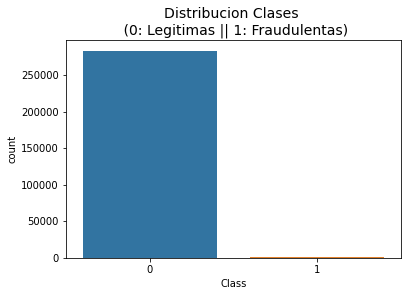

In [16]:
# Se representa mediante un gráfico de barras
sns.countplot('Class', data=df)
plt.title('Distribucion Clases \n (0: Legitimas || 1: Fraudulentas)', fontsize=14)

print('Las transacciones fraudulentas corresponden al ', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% de las transacciones')
print('Las transacciones no fraudulentas corresponden al ', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% de las transacciones')

A continuacion, analizamos la distrbución de las variables Tiempo (*Time*) y la cantidad de la transacción (*Amount*), sin escalar.

Text(0.5, 1.0, 'Distribución del atributo Time')

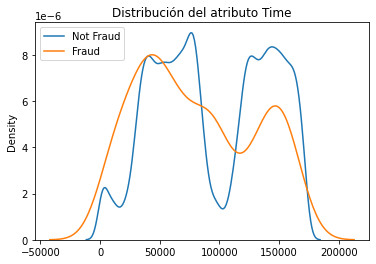

In [10]:
#visualizations of time and amount
class_0 = df.loc[df['Class'] == 0]
class_1 = df.loc[df['Class'] == 1]

sns.distplot(class_0[['Time']], hist=False, label='Not Fraud')
sns.distplot(class_1[['Time']], hist=False, label='Fraud')
plt.legend()
plt.title("Distribución del atributo Time")

Text(0.5, 1.0, 'Distribución del atributo Amount')

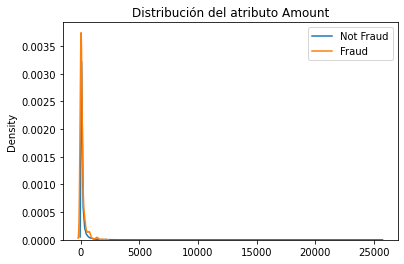

In [11]:
sns.distplot(class_0[['Amount']], hist=False, label='Not Fraud')
sns.distplot(class_1[['Amount']], hist=False, label='Fraud')
plt.legend()
plt.title("Distribución del atributo Amount")

## **Analisis relacion variables**

Mediante un heatmap se presenta la correlación entre las variables.

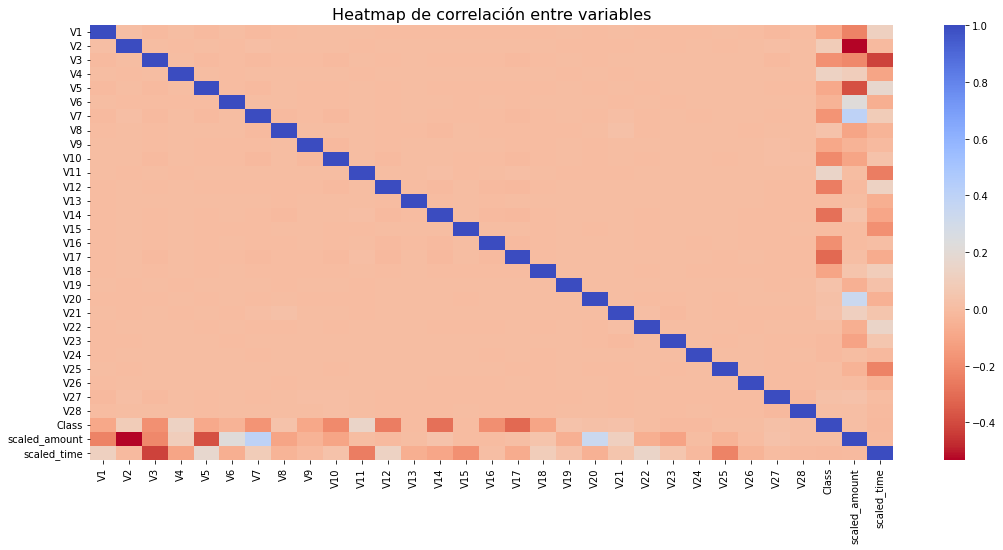

In [17]:
rcParams['figure.figsize']=18,8
sns.heatmap(df.corr(), cmap='coolwarm_r', annot_kws={'size':20})
plt.title('Heatmap de correlación entre variables',fontsize=16)
plt.show()

A continuación, mediante el uso de gráficos de caja vemos la distribución de las variables con mayor correlación con la clase (tanto positiva como negativa):

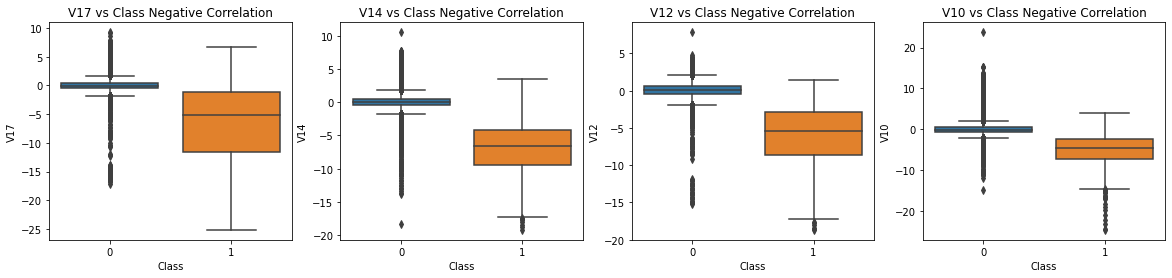

In [18]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=df, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=df, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=df, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=df, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

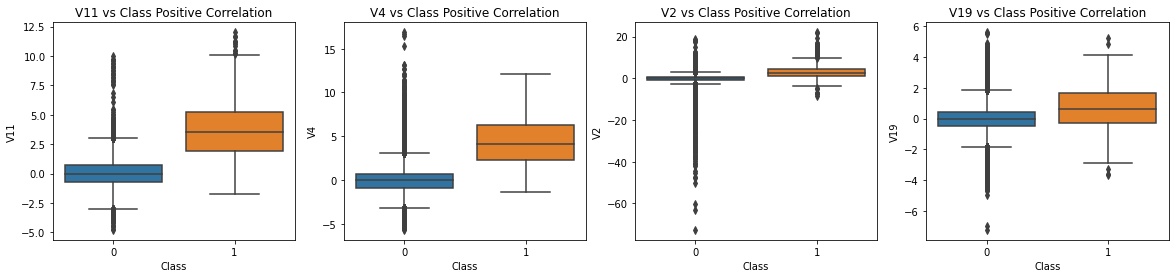

In [19]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=df, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=df, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=df, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=df, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

# **Algoritmos de Machine Learning**

## Conjunto de entrenamiento y test

Un punto común en la mayoría de los modelos de algoritmos de aprendizaje supervisado es la separación del conjunto de datos en un conjunto de entrenamiento y otro de test. Esto se aplica para evitar que el algoritmo sea dependiente de los datos utilizados durante su entrenamiento, evitando problemas como el sobreentrenamiento. 

El sobreentrenamiento se puede definir, informalmente, como el peligro que corremos al sobreentrenar un modelo. Consiste en que este acabe respondiendo estrictamente a las propiedades del juego de datos de entrenamiento y que sea incapaz de extrapolarse con niveles de acierto adecuados a otros juegos de datos que puedan aparecer en un futuro.

Para prevenir el sobreentrenamiento del conjunto, se separan el conjunto en dos subconjuntos. Un subconjunto utilizado para el entrenamiento de los modelos, que corresponde aproximadamente al 80% del original. El 20% restante se utilizará para evaluar los modelos creados.

Primero, se separa el conjunto de datos en la variable objetivo (y) y los regresores (X).

In [20]:
# Se separa la variable objetivo del resto
X = df.drop(columns=['Class'])
y = df['Class']

Para separar el conjunto de datos se utiliza el método de sklearn [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Además, al tratarse de un conjunto de datos fuertemente desbalanceado, debemos utilizar la opción *stratify*, para que el porcentaje de las clases se mantenga en el conjunto de test y de entrenamiento.

In [63]:
# Se separa en conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state = 24)

training_fraud = sum(y_train.values)
training_fraud_pct = sum(y_train.values)/len(y_train.values)*100
test_fraud = sum(y_test.values)
test_fraud_pct = sum(y_test.values)/len(y_test.values)*100

print("X train: {}".format(X_train.shape))
print("X test: {}".format(X_test.shape))
print("y train: {}".format(y_train.shape))
print("y test: {}".format(y_test.shape))
print("Fraud in train set: {},   {:2f}%".format(training_fraud, training_fraud_pct))
print("Fraud in test set: {},   {:2f}%".format(test_fraud, test_fraud_pct))

X train: (198608, 30)
X test: (85118, 30)
y train: (198608,)
y test: (85118,)
Fraud in train set: 331,   0.166660%
Fraud in test set: 142,   0.166827%


In [21]:
# Se separa en conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state = 24)

training_fraud = sum(y_train.values)
training_fraud_pct = sum(y_train.values)/len(y_train.values)*100
test_fraud = sum(y_test.values)
test_fraud_pct = sum(y_test.values)/len(y_test.values)*100

print("X train: {}".format(X_train.shape))
print("X test: {}".format(X_test.shape))
print("y train: {}".format(y_train.shape))
print("y test: {}".format(y_test.shape))
print("Fraud in train set: {},   {:2f}%".format(training_fraud, training_fraud_pct))
print("Fraud in test set: {},   {:2f}%".format(test_fraud, test_fraud_pct))

X train: (226980, 30)
X test: (56746, 30)
y train: (226980,)
y test: (56746,)
Fraud in train set: 378,   0.166534%
Fraud in test set: 95,   0.167413%


## **Desbalanceo de los datos**

Uno de los mayores problemas en la detección de fraude es el gran desbalanceo de los datos, ya que el porcentaje de transacciones fraudulentas es de 0.17%. Esto complica la tarea de entrenar los algoritmos ya que no están diseñados para hacer frente a una gran diferencia entre el número de casos pertenecientes a diferentes clases. 

Se han propuesto muchas soluciones para hacer frente a este problema, uno de los métodos más comunes es aplicar técnicas de remuestreo. Los métodos de remuestreo operan a nivel de datos, agregando un paso de preprocesamiento para reequilibrar el conjunto de datos antes de aplicar el algoritmo de entrenamiento. El remuestreo se puede lograr eliminando ejemplos de la clase mayoritaria (undersampling), agregando ejemplos de la clase minoritaria (oversampling) o una combinación de undersampling y oversampling (hybrid).

### **Oversampling**

En el oversampling, al replicar la clase minoritaria hasta que las dos clases tengan la misma frecuencia aumenta el riesgo de overfitting al sesgar el modelo hacia la clase minoritaria. Otros inconvenientes de este enfoque es que aumenta el tiempo de formación al introducir nuevas observaciones. Esto puede ser particularmente ineficaz cuando el conjunto de datos original es bastante grande. En nuestro caso, aplicaremos el método ADASYN (*Adaptive Synthetic Sampling*).

In [22]:
ada = ADASYN(random_state=42)
X_ada_train, y_ada_train = ada.fit_resample(X_train, y_train)

In [23]:
print("Entradas en el conjunto desbalanceado: {}".format(X_train.shape[0]))
print("Entradas en el conjunto con overfitting: {}".format(X_ada_train.shape[0]))

Entradas en el conjunto desbalanceado: 226980
Entradas en el conjunto con overfitting: 453183


Text(0.5, 1.0, 'Distribucion Clases con ADASYN \n (0: Legitimas || 1: Fraudulentas)')

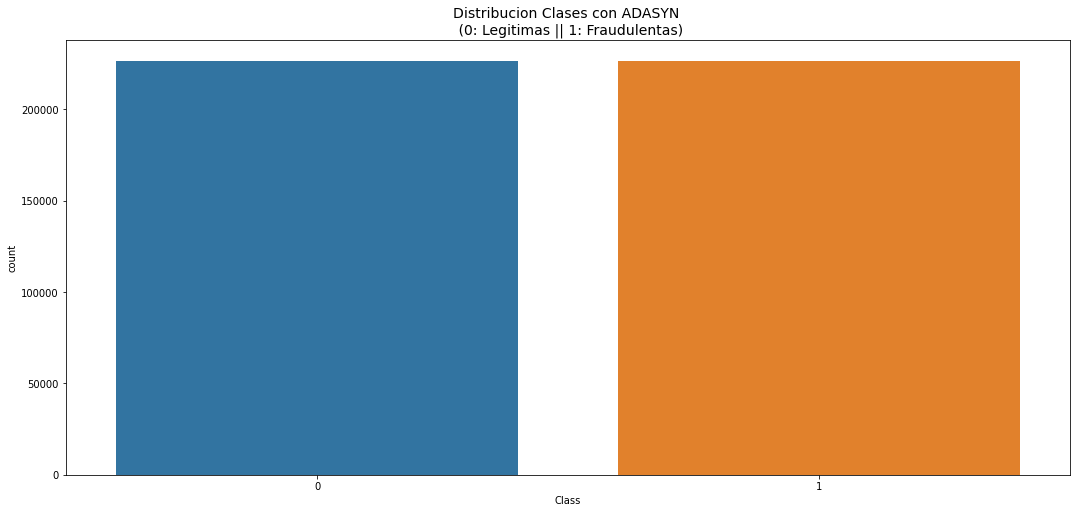

In [24]:
# Se representa mediante un gráfico de barras
sns.countplot(y_ada_train)
plt.title('Distribucion Clases con ADASYN \n (0: Legitimas || 1: Fraudulentas)', fontsize=14)

### **Undersampling**

En el undersampling, al eliminar observaciones al azar se corre el riesgo de eliminar las observaciones relevantes del conjunto de datos, ya que la eliminación se realiza de manera no supervisada. En la práctica, esta técnica se adopta a menudo ya que es simple y acelera la fase de aprendizaje. En nuestro caso aplicaremos en RandomUnderSampler

In [25]:
rus = RandomUnderSampler(random_state=42)
X_un_train, y_un_train = rus.fit_resample(X_train, y_train)

In [26]:
print("Entradas en el conjunto desbalanceado: {}".format(X_train.shape[0]))
print("Entradas en el conjunto con underfitting: {}".format(X_un_train.shape[0]))

Entradas en el conjunto desbalanceado: 226980
Entradas en el conjunto con underfitting: 756


Text(0.5, 1.0, 'Distribucion Clases con UnderSampler \n (0: Legitimas || 1: Fraudulentas)')

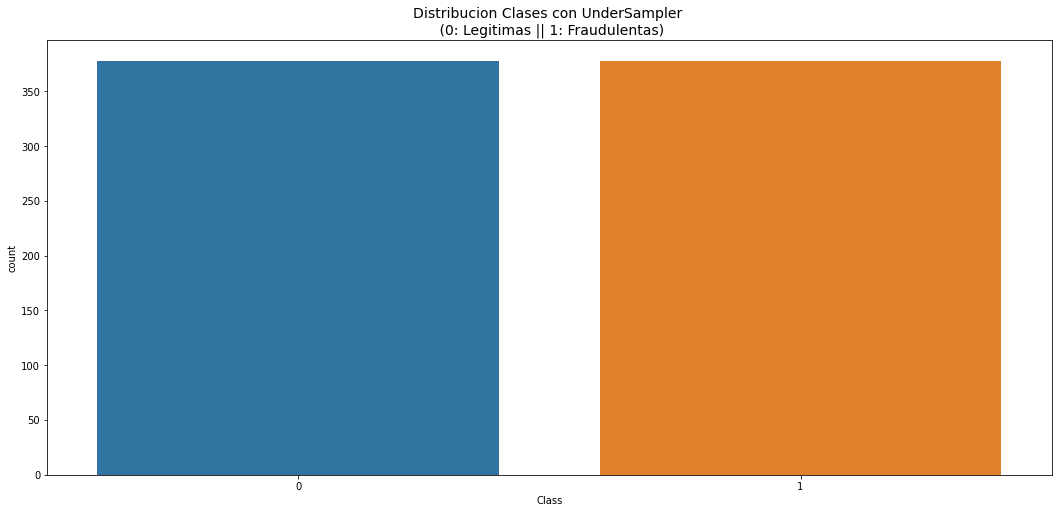

In [27]:
# Se representa mediante un gráfico de barras
sns.countplot(y_un_train)
plt.title('Distribucion Clases con UnderSampler \n (0: Legitimas || 1: Fraudulentas)', fontsize=14)

## Métricas de evaluación de modelos

Debido a que se trata de un problema con datos balanceados hay métricas como el recall que pueden dar resultados engañosos. Una medida bien aceptada para la clasificación desbalanceada es el área bajo la curva ROC (AUC). A continuación, se presenta una función creada para evaluar los distintos modelos, con las siguientes métricas:

* Recall
* Precision
* F1-score
* Accuracy
* FPR
* ROC AUC
* Matriz de confusión

In [28]:
def evaluate_model(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TP = cm[1][1]
    FP= cm[0][1]
    FN = cm[1][0]
    TN = cm[0][0]
    
    s1 = recall_score(y_test, y_pred, pos_label=1, average='binary').round(4)
    s2 = precision_score(y_test, y_pred, pos_label=1, average='binary').round(4)
    s3 = f1_score(y_test, y_pred, pos_label=1, average='binary').round(4)
    s4 = accuracy_score(y_test, y_pred).round(4)
    s5 = (FP/(FP+TN))
    s6 = roc_auc_score(y_test, y_pred, average='weighted').round(4)
    print("Recall ", s1)
    print("Precision ", s2)
    print("f1 score ", s3)
    print("Accuracy ", s4)
    print("FPR ", s5)
    print("ROC_AUC ", s6)
    print("\nConfusion Matrix:\n ",cm)

## **Modelos de Machine Learning**
## **SVM**

Las máquinas de soporte vectorial (en inglés, Support Vector Machines o SVM) es el nombre con el cual se conoce un
algoritmo de aprendizaje supervisado capaz de resolver problemas de clasificación, tanto lineales como no lineales. Actualmente
está considerado como uno de los algoritmos más potentes en reconocimiento de patrones.

In [97]:
# Set the parameters by cross-validation
tuned_parameters_svm = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "degree": [3, 4, 5], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]}
]


svm_parameters = GridSearchCV(SVC(), tuned_parameters_svm, cv=5, scoring='f1', n_jobs=-1)
svm_parameters.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'degree': [3, 4, 5],
                          'gamma': [0.001, 0.0001], 'kernel': ['poly']}],
             scoring='f1')

In [98]:
svm_parameters.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

### Unbalance data

In [ ]:
svm = SVC(C=100, kernel='rbf', gamma=0.001)
svm.fit(X_train, y_train)

In [29]:
svm = SVC(C=100, kernel='rbf', gamma=0.001)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

In [81]:
evaluate_model(y_test, svm_pred)

Recall  0.8526
Precision  0.9419
f1 score  0.895
Accuracy  0.9997
FPR  8.825969532753173e-05
ROC_AUC  0.9263

Confusion Matrix:
  [[56646     5]
 [   14    81]]


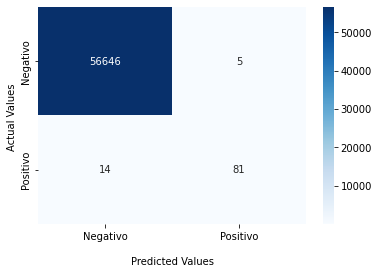

In [3]:
cf_matrix = [[56646, 5], [14, 81]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

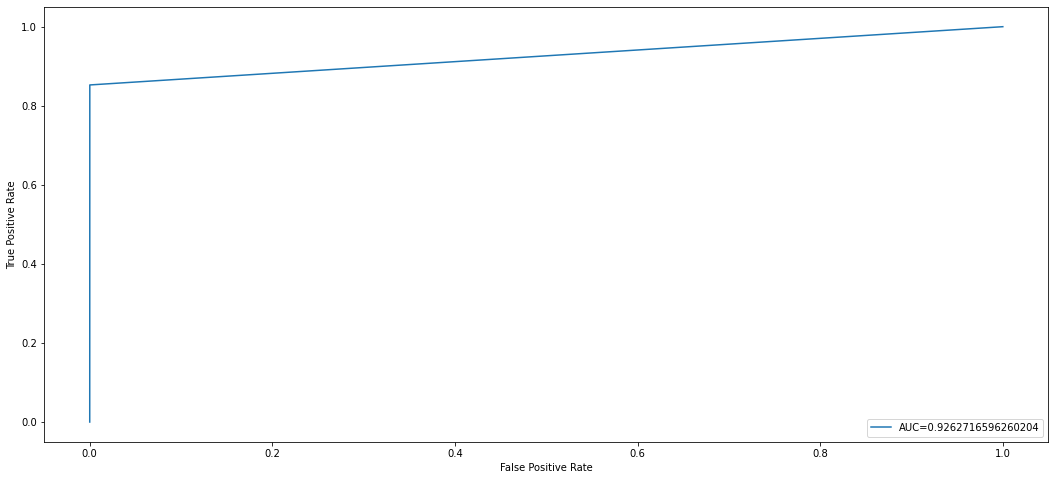

In [82]:
fpr, tpr, _ = roc_curve(y_test, svm_pred)
auc = roc_auc_score(y_test,  svm_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Oversampled data

In [80]:
svm_ada = SVC(C=100, kernel='rbf', gamma=0.001)
svm_ada.fit(X_ada_train, y_ada_train)
svm_ada_pred = svm_ada.predict(X_test)

In [82]:
evaluate_model(y_test, svm_ada_pred)

Recall  0.8211
Precision  0.0761
f1 score  0.1393
Accuracy  0.983
FPR  0.01671638629503451
ROC_AUC  0.9022

Confusion Matrix:
  [[55704   947]
 [   17    78]]


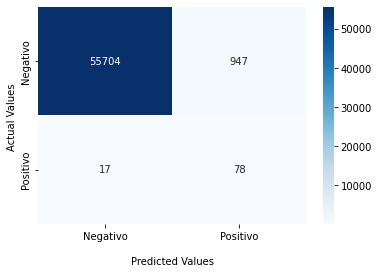

In [4]:
cf_matrix = [[55704, 947], [17, 78]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

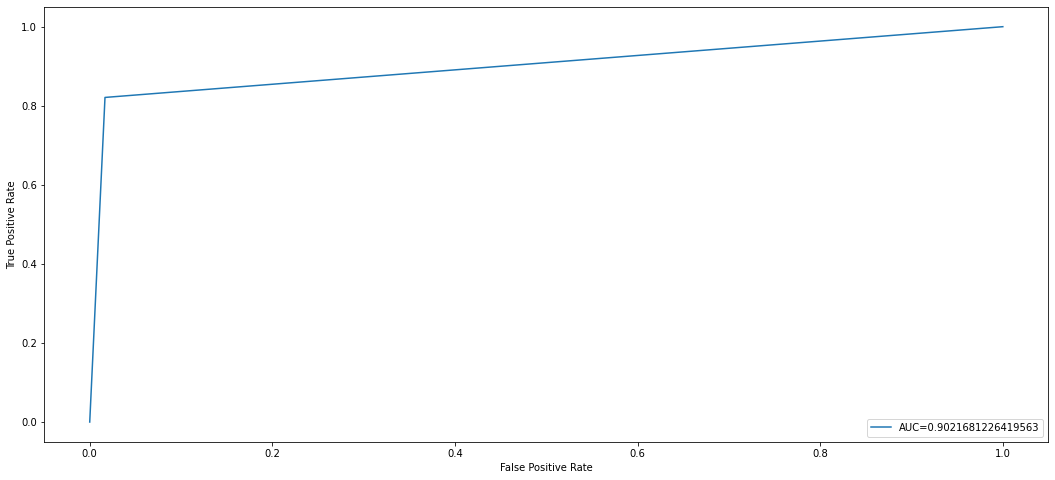

In [83]:
fpr, tpr, _ = roc_curve(y_test, svm_ada_pred)
auc = roc_auc_score(y_test,  svm_ada_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Undersampled data

In [21]:
svm_un = SVC(C=100, kernel='rbf', gamma=0.001)
svm_un.fit(X_un_train, y_un_train)
svm_un_pred = svm_un.predict(X_test)

In [23]:
evaluate_model(y_test, svm_un_pred)

Recall  0.9263
Precision  0.0544
f1 score  0.1028
Accuracy  0.9729
FPR  0.0269898148311592
ROC_AUC  0.9497

Confusion Matrix:
  [[55122  1529]
 [    7    88]]


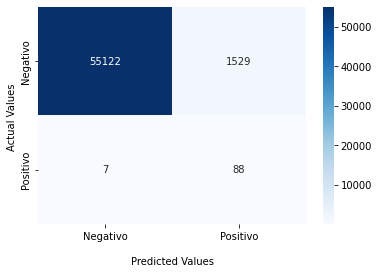

In [5]:
cf_matrix = [[55122, 1529], [7, 88]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

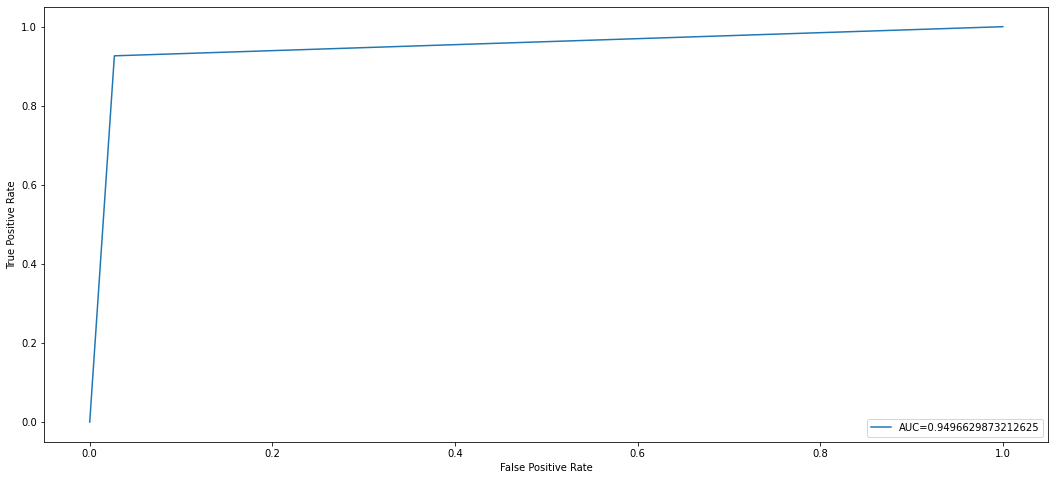

In [24]:
fpr, tpr, _ = roc_curve(y_test, svm_un_pred)
auc = roc_auc_score(y_test,  svm_un_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Analizando las métricas y la matriz de confusión se puede observar una mejora en la sensibilidad, el porcentaje de transacciones fraudulentas predichas como tal, del modelo con datos desbalanceados al modelo con técnicas de undersampling. Sin embargo esto impacta negativamente en la precisión del modelo. El modelo con técnicas de undersampling es además el modelo con una mayor puntuación AUC ROC y sensibilidad.

## **Naïve Bayes**

El algoritmo de clasificación de Naïve Bayes se basa en el concepto de probabilidad condicional y busca maximizar la verosimilitud del modelo. 

Estos modelos son llamados algoritmos “Naive”, o “Inocentes” en español. En ellos se asume que las variables predictoras son independientes entre sí. y esto no siempre es cierto en los conjuntos de datos reales. Las ventajas del algoritmo de clasificación de Naïve Bayes son su simplicidad y eficiencia computacional. Es especialmente adecuado para juegos de datos con pocos registros, ya que no requiere de un gran entrenamiento para empezar a ser eficaz.

En este modelo no se utilizan parámetros para optimizar.

### Unbalance data

In [25]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)

In [27]:
evaluate_model(y_test, nb_pred)

Recall  0.9053
Precision  0.0657
f1 score  0.1225
Accuracy  0.9783
FPR  0.021588321477114262
ROC_AUC  0.9418

Confusion Matrix:
  [[55428  1223]
 [    9    86]]


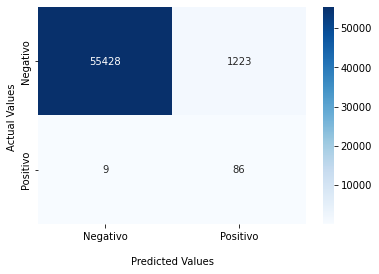

In [6]:
cf_matrix = [[55428, 1223], [9, 86]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

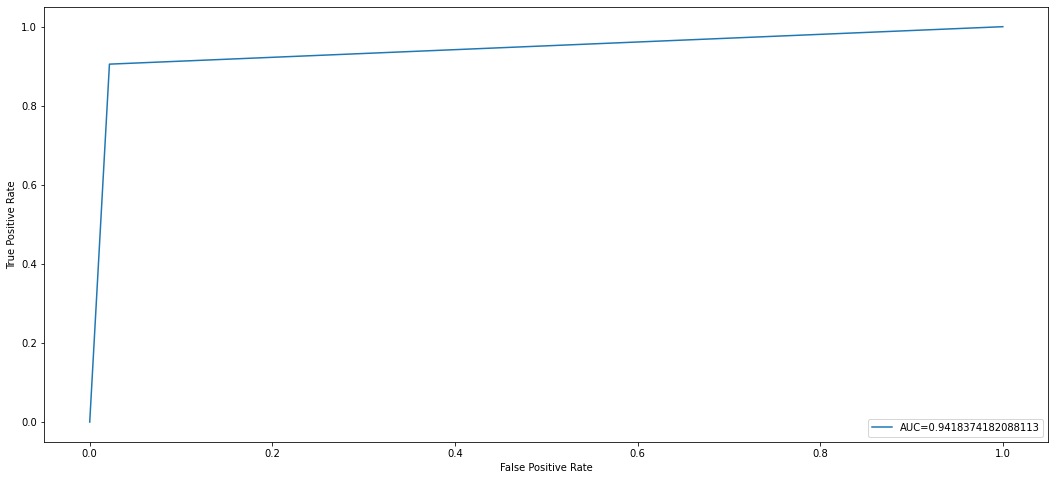

In [28]:
fpr, tpr, _ = roc_curve(y_test, nb_pred)
auc = roc_auc_score(y_test,  nb_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Oversampled data

In [29]:
nb_ada = GaussianNB()
nb_ada.fit(X_ada_train, y_ada_train)
nb_ada_pred = nb_ada.predict(X_test)

In [30]:
evaluate_model(y_test, nb_ada_pred)

Recall  0.9263
Precision  0.0342
f1 score  0.0659
Accuracy  0.956
FPR  0.043900372455914285
ROC_AUC  0.9412

Confusion Matrix:
  [[54164  2487]
 [    7    88]]


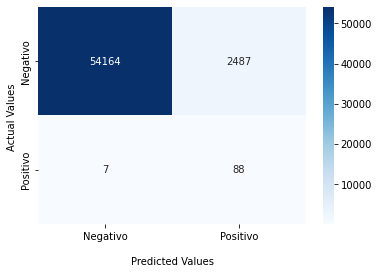

In [7]:
cf_matrix = [[54164, 2487], [7, 88]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

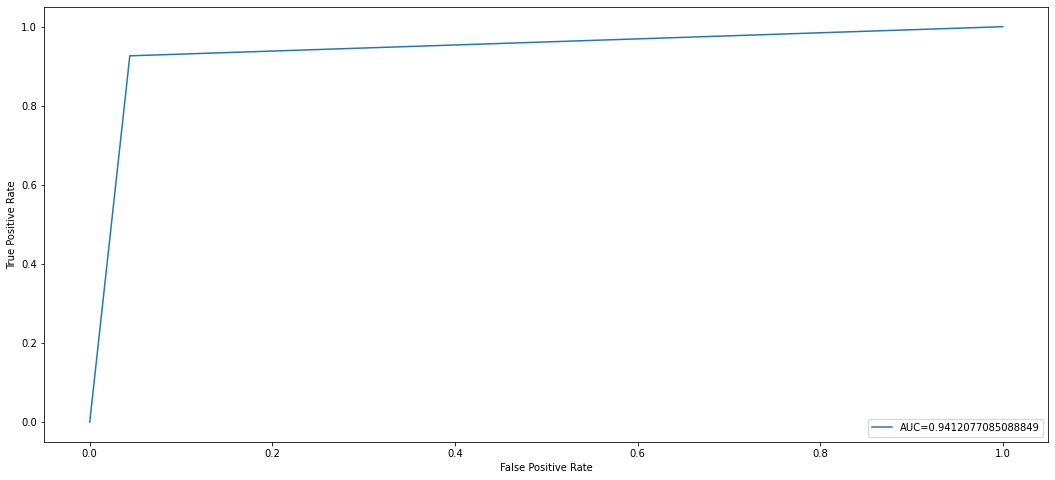

In [31]:
fpr, tpr, _ = roc_curve(y_test, nb_ada_pred)
auc = roc_auc_score(y_test,  nb_ada_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Undersampled data

In [32]:
nb_un = GaussianNB()
nb_un.fit(X_un_train, y_un_train)
nb_un_pred = nb_un.predict(X_test)

In [33]:
evaluate_model(y_test, nb_un_pred)

Recall  0.9263
Precision  0.0503
f1 score  0.0953
Accuracy  0.9706
FPR  0.029355174665937053
ROC_AUC  0.9485

Confusion Matrix:
  [[54988  1663]
 [    7    88]]


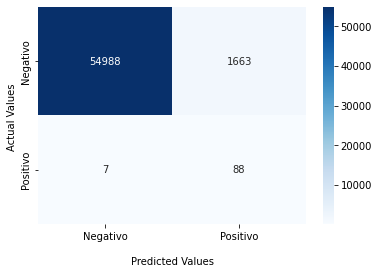

In [8]:
cf_matrix = [[54988, 1663], [7, 88]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

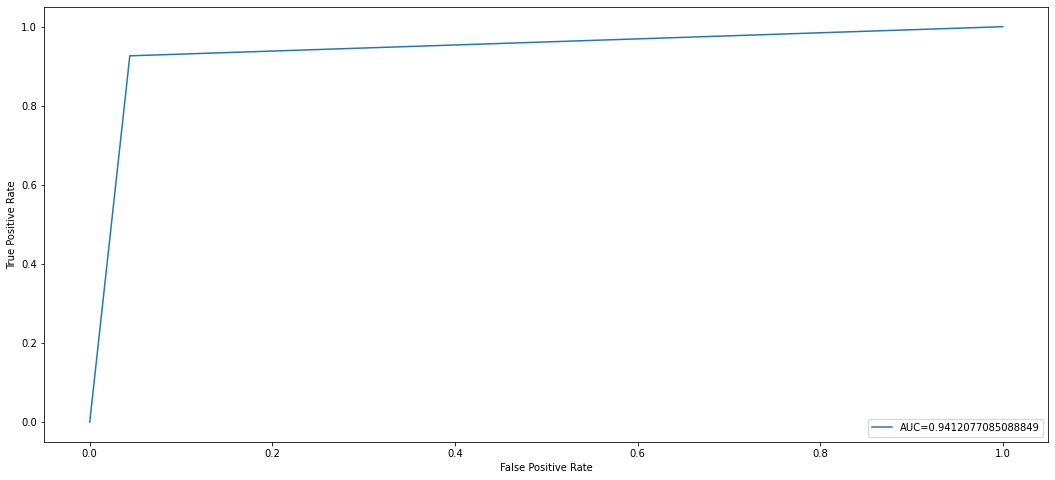

In [34]:
fpr, tpr, _ = roc_curve(y_test, nb_ada_pred)
auc = roc_auc_score(y_test,  nb_ada_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Analizando las métricas y la matriz de confusión se puede observar una mejora en la sensibilidad del modelo con datos desbalanceados a los dos modelos con técnicas de remuestreo. Sin embargo esto impacta negativamente en la precisión del modelo, afectando peor al modelo con técnicas de oversampling. El modelo con técnicas de undersampling es además el modelo con una mayor puntuación AUC ROC y sensibilidad.

## **Regresión Logística**

El modelo de regresión logística es un método de regresión que permite estimar la probabilidad de una variable cualitativa binaria en función de una o múltiples variables cuantitativas. Una de las principales aplicaciones de la regresión logística es la de clasificación binaria, en el que las observaciones se clasifican en un grupo u otro dependiendo del valor que tome la variable empleada como predictor.

In [68]:
# Set the parameters by cross-validation
tuned_parameters_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}


lr_parameters = GridSearchCV(LogisticRegression(), tuned_parameters_lr, cv=5, n_jobs=-1, scoring='f1')
lr_parameters.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='f1')

In [69]:
lr_parameters.best_params_

{'C': 10, 'penalty': 'l2'}

### Unbalance data

In [70]:
lr = LogisticRegression(penalty='l2', C=10)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [72]:
evaluate_model(y_test, lr_pred)

Recall  0.7579
Precision  0.878
f1 score  0.8136
Accuracy  0.9994
FPR  0.00017651939065506346
ROC_AUC  0.8789

Confusion Matrix:
  [[56641    10]
 [   23    72]]


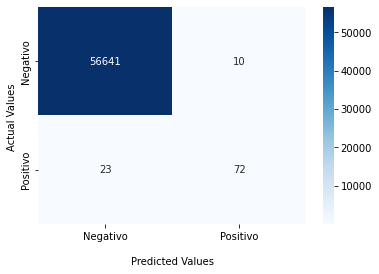

In [9]:
cf_matrix = [[56641, 10], [23, 72]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

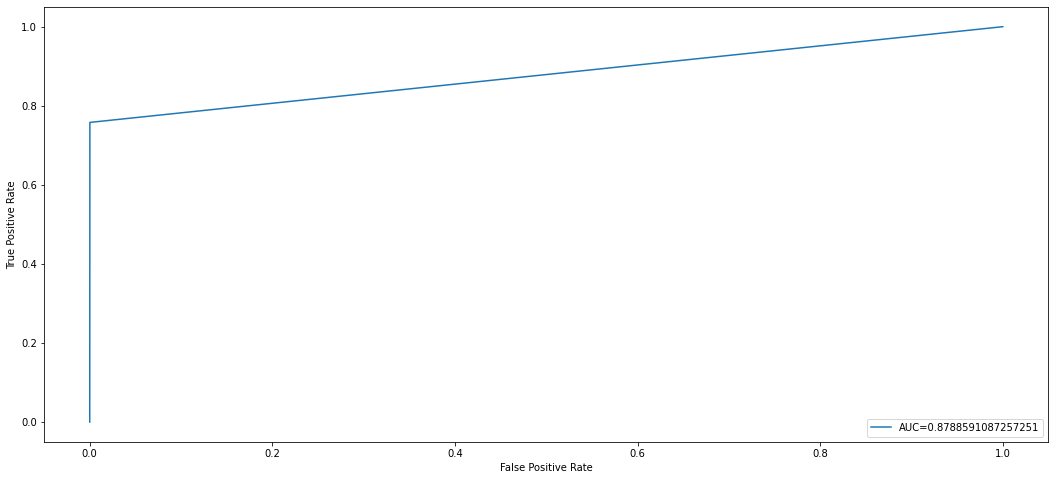

In [73]:
fpr, tpr, _ = roc_curve(y_test, lr_pred)
auc = roc_auc_score(y_test,  lr_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Oversampled data

In [74]:
lr_ada = LogisticRegression(penalty='l2', C=10)
lr_ada.fit(X_ada_train, y_ada_train)
lr_ada_pred = lr_ada.predict(X_test)

In [75]:
evaluate_model(y_test, lr_ada_pred)

Recall  0.9474
Precision  0.0183
f1 score  0.036
Accuracy  0.9151
FPR  0.08499408660041305
ROC_AUC  0.9312

Confusion Matrix:
  [[51836  4815]
 [    5    90]]


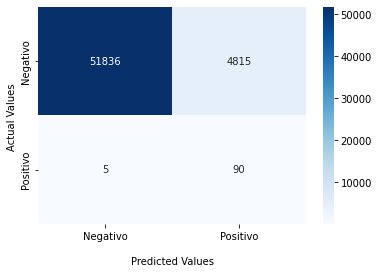

In [10]:
cf_matrix = [[51836, 4815], [5, 90]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

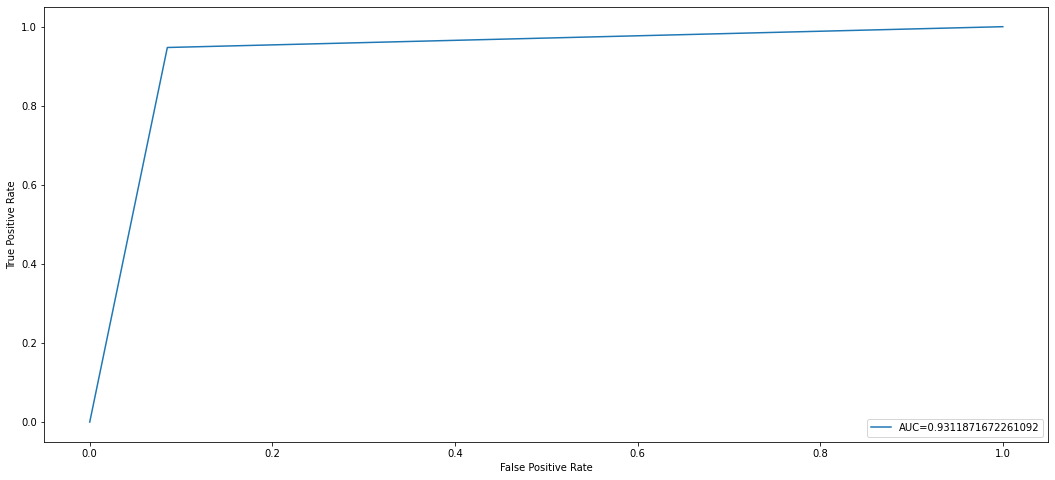

In [76]:
fpr, tpr, _ = roc_curve(y_test, lr_ada_pred)
auc = roc_auc_score(y_test,  lr_ada_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Undersampled data

In [77]:
lr_un = LogisticRegression(penalty='l2', C=10)
lr_un.fit(X_un_train, y_un_train)
lr_un_pred = lr_un.predict(X_test)

In [78]:
evaluate_model(y_test, lr_un_pred)

Recall  0.9368
Precision  0.0376
f1 score  0.0724
Accuracy  0.9598
FPR  0.040175813313092446
ROC_AUC  0.9483

Confusion Matrix:
  [[54375  2276]
 [    6    89]]


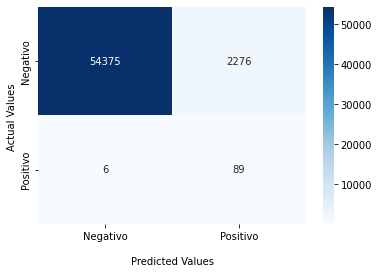

In [11]:
cf_matrix = [[54375, 2276], [6, 89]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

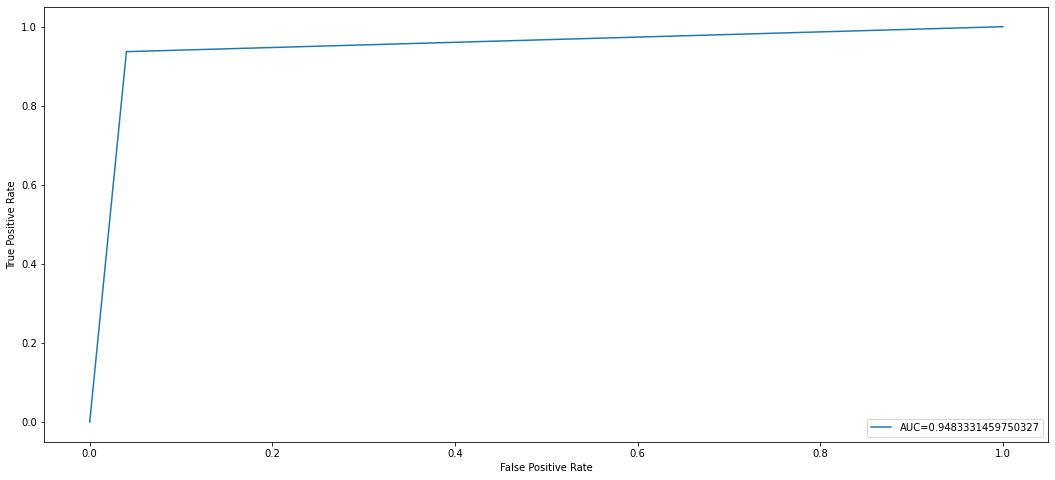

In [79]:
fpr, tpr, _ = roc_curve(y_test, lr_un_pred)
auc = roc_auc_score(y_test,  lr_un_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Analizando las métricas y la matriz de confusión se puede observar una mejora en la sensibilidad del modelo con datos desbalanceados a los dos modelos con técnicas de remuestreo, siendo un poco más sensible el modelo con técnicas de oversampling. Sin embargo esto impacta negativamente en la precisión del modelo, afectando peor al modelo con técnicas de oversampling. El modelo con técnicas de undersampling es además el modelo con una mayor puntuación AUC ROC y sensibilidad del 94.83%.

## **Arbol de decisión**

Los árboles de decisión son uno de los modelos de minería de datos más comunes y estudiados, y no precisamente por su capacidad predictiva, superada generalmente por otros modelos más complejos, sino por su alta capacidad explicativa y la facilidad para interpretar el modelo generado.

los árboles de decisión son un modelo de minería de datos que intenta subdividir el espacio de datos de entrada para generar regiones disjuntas, de forma que todos los elementos que pertenezcan a una misma región sean de la misma clase, la cual es utilizada como representante o clase de dicha región. Si una región contiene datos de diferentes clases es subdividida en regiones más pequeñas siguiendo el mismo criterio, hasta particionar todo el espacio de entrada en regiones disjuntas que solamente contienen elementos de una misma clase.

In [61]:
# Set the parameters by cross-validation
tuned_parameters_dt = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [2, 10, 20, 50, 100]
}


dt_parameters = GridSearchCV(DecisionTreeClassifier(), tuned_parameters_dt, cv=5,n_jobs=-1, scoring='f1')
dt_parameters.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [2, 10, 20, 50, 100]},
             scoring='f1')

In [62]:
dt_parameters.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2}

### Unbalance data

In [35]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=2)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [36]:
evaluate_model(y_test, dt_pred)

Recall  0.8421
Precision  0.9091
f1 score  0.8743
Accuracy  0.9996
FPR  0.00014121551252405077
ROC_AUC  0.921

Confusion Matrix:
  [[56643     8]
 [   15    80]]


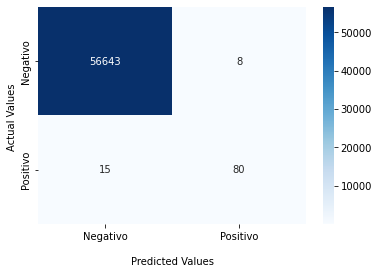

In [12]:
cf_matrix = [[56643, 8], [15, 80]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

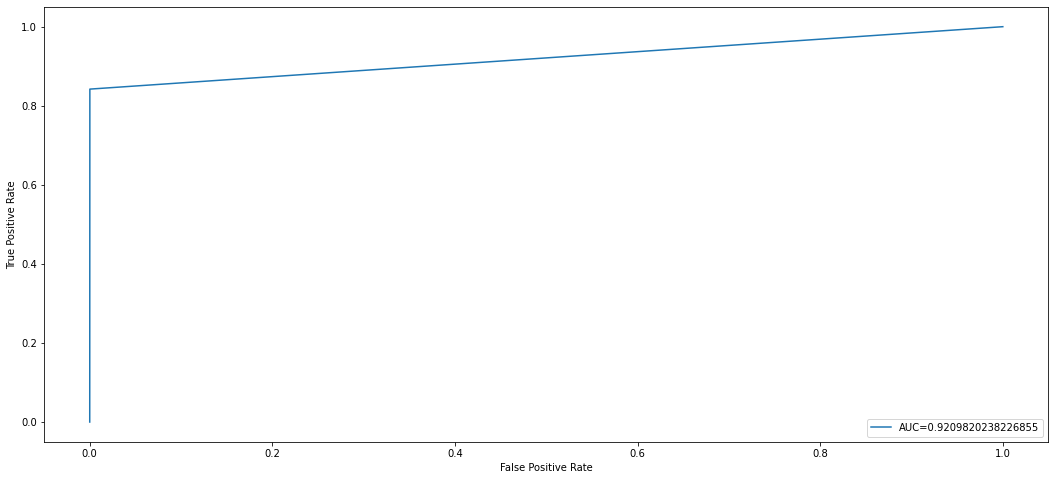

In [37]:
fpr, tpr, _ = roc_curve(y_test, dt_pred)
auc = roc_auc_score(y_test,  dt_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Oversampled data

In [40]:
dt_ada = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=2)
dt_ada.fit(X_ada_train, y_ada_train)
dt_ada_pred = dt_ada.predict(X_test)

In [41]:
evaluate_model(y_test, dt_ada_pred)

Recall  0.9474
Precision  0.0167
f1 score  0.0327
Accuracy  0.9063
FPR  0.09380240419410073
ROC_AUC  0.9268

Confusion Matrix:
  [[51337  5314]
 [    5    90]]


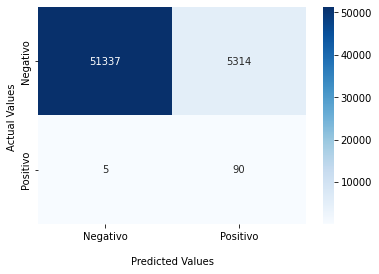

In [13]:
cf_matrix = [[51337, 5314], [5, 90]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

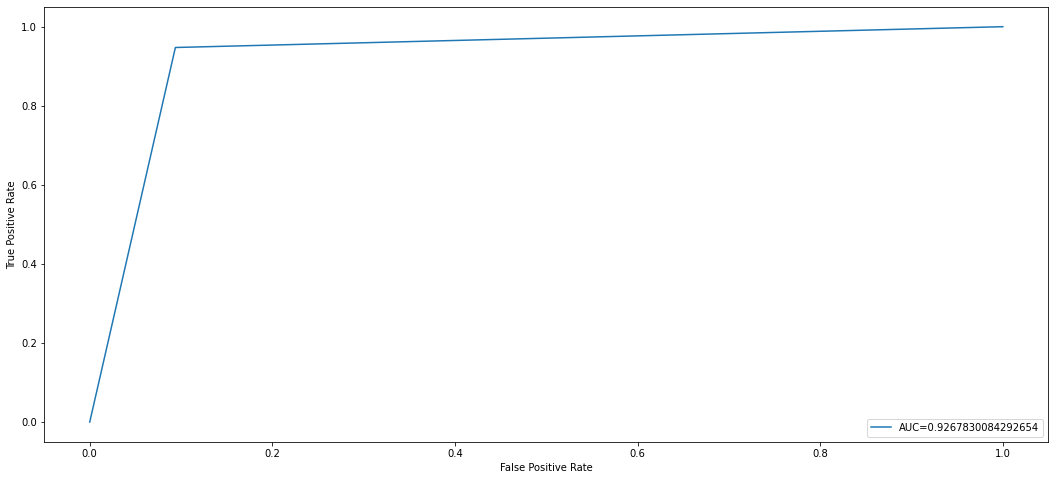

In [42]:
fpr, tpr, _ = roc_curve(y_test, dt_ada_pred)
auc = roc_auc_score(y_test,  dt_ada_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Undersampled data

In [43]:
dt_un = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=2)
dt_un.fit(X_un_train, y_un_train)
dt_un_pred = dt_un.predict(X_test)

In [45]:
evaluate_model(y_test, dt_un_pred)

Recall  0.9263
Precision  0.0258
f1 score  0.0501
Accuracy  0.9412
FPR  0.05874565321000512
ROC_AUC  0.9338

Confusion Matrix:
  [[53323  3328]
 [    7    88]]


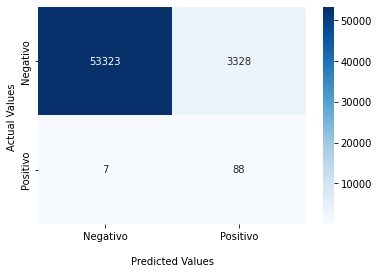

In [14]:
cf_matrix = [[53323, 3328], [7, 88]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

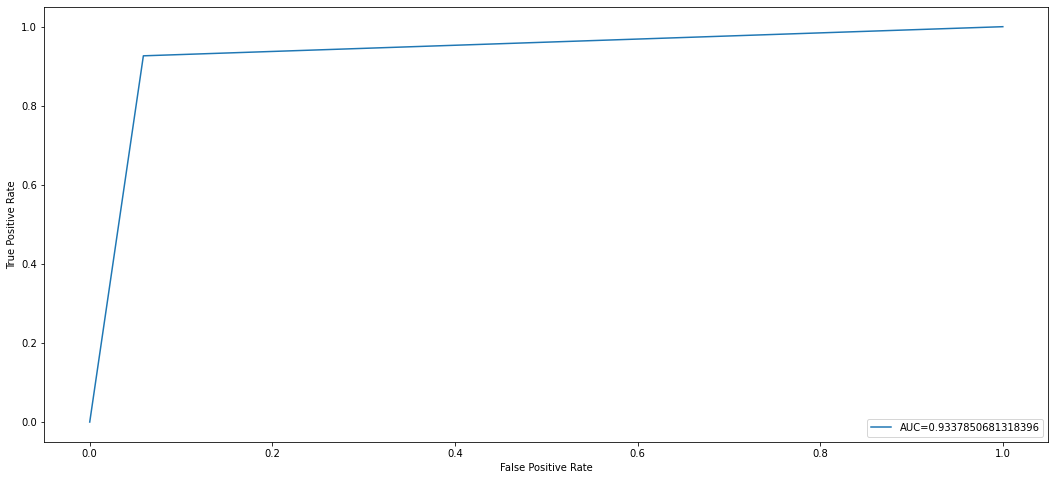

In [46]:
fpr, tpr, _ = roc_curve(y_test, dt_un_pred)
auc = roc_auc_score(y_test,  dt_un_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Analizando las métricas y la matriz de confusión se puede observar una mejora en la sensibilidad del modelo con datos desbalanceados a los dos modelos con técnicas de remuestreo, siendo un poco más sensible el modelo con técnicas de oversampling. Sin embargo esto impacta negativamente en la precisión del modelo, afectando peor al modelo con técnicas de oversampling. El modelo con técnicas de undersampling es además el modelo con una mayor puntuación AUC ROC y sensibilidad del 92.63%.

## **Random Forest**

El Random Forest funciona como una combinación de árboles de decisiones, tal que cada árbol depende de los valores de un vector aleatorio probado independientemente y con la misma distribución para cada uno de estos. Es una modificación sustancial de bagging que construye una larga colección de árboles no correlacionados y luego los promedia

In [77]:
# Set the parameters by cross-validation
tuned_parameters_rf = {
    'n_estimators': [50, 100, 200],
    'criterion': ['entropy', 'gini'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [2, 10, 20, 50, 100]
}


rf_parameters = GridSearchCV(RandomForestClassifier(), tuned_parameters_rf, cv=5, n_jobs=-1, scoring='f1')
rf_parameters.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [2, 10, 20, 50, 100],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [78]:
rf_parameters.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 2,
 'n_estimators': 200}

### Unbalance data

In [48]:
rf = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=15, min_samples_leaf=2)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [49]:
evaluate_model(y_test, rf_pred)

Recall  0.8526
Precision  0.9419
f1 score  0.895
Accuracy  0.9997
FPR  8.825969532753173e-05
ROC_AUC  0.9263

Confusion Matrix:
  [[56646     5]
 [   14    81]]


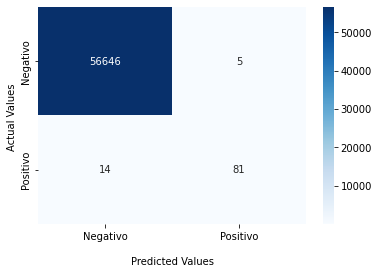

In [15]:
cf_matrix = [[56646, 5], [14, 81]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

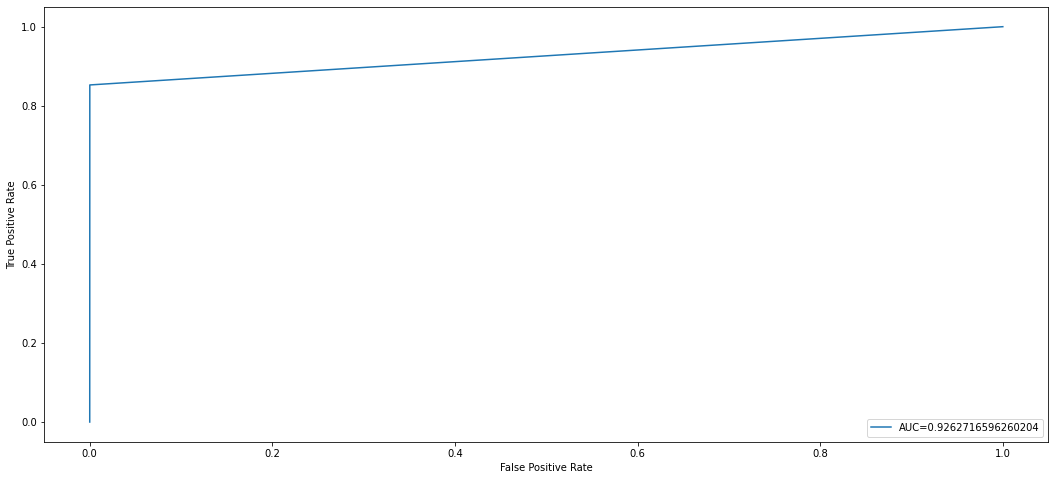

In [50]:
fpr, tpr, _ = roc_curve(y_test, rf_pred)
auc = roc_auc_score(y_test,  rf_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Oversampled data

In [51]:
rf_ada = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=15, min_samples_leaf=2)
rf_ada.fit(X_ada_train, y_ada_train)
rf_ada_pred = rf_ada.predict(X_test)

In [53]:
evaluate_model(y_test, rf_ada_pred)

Recall  0.9053
Precision  0.4831
f1 score  0.63
Accuracy  0.9982
FPR  0.0016239783940265838
ROC_AUC  0.9518

Confusion Matrix:
  [[56559    92]
 [    9    86]]


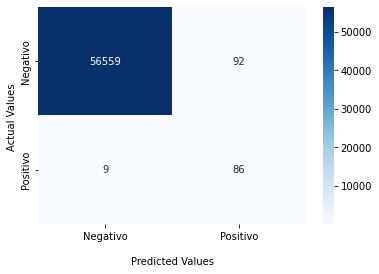

In [16]:
cf_matrix = [[56559, 92], [9, 86]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

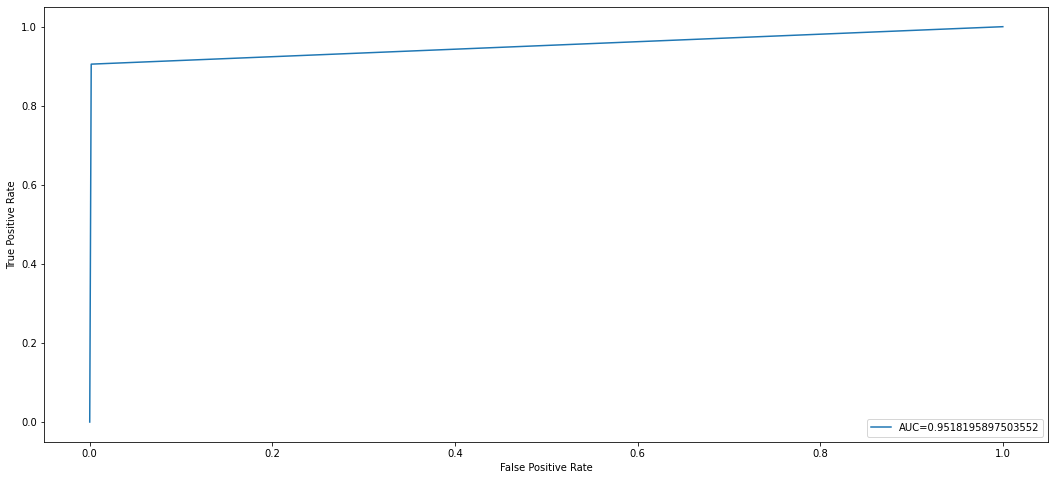

In [54]:
fpr, tpr, _ = roc_curve(y_test, rf_ada_pred)
auc = roc_auc_score(y_test,  rf_ada_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Undersampled data

In [55]:
rf_un = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=15, min_samples_leaf=2)
rf_un.fit(X_un_train, y_un_train)
rf_un_pred = rf_un.predict(X_test)

In [57]:
evaluate_model(y_test, rf_un_pred)

Recall  0.9263
Precision  0.0689
f1 score  0.1282
Accuracy  0.9789
FPR  0.02100580748795255
ROC_AUC  0.9527

Confusion Matrix:
  [[55461  1190]
 [    7    88]]


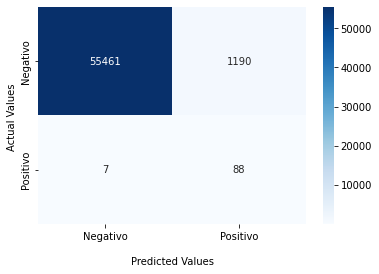

In [17]:
cf_matrix = [[55461, 1190], [7, 88]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

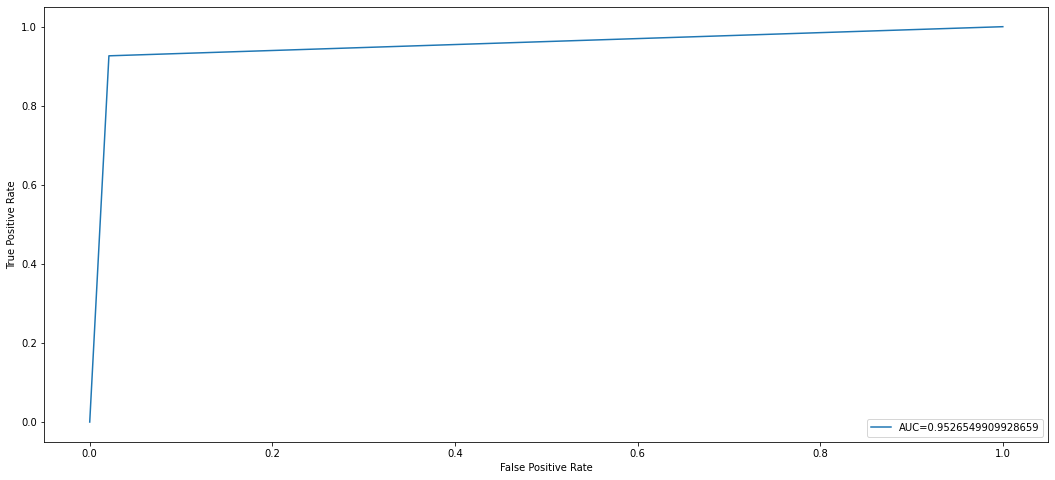

In [58]:
fpr, tpr, _ = roc_curve(y_test, rf_un_pred)
auc = roc_auc_score(y_test,  rf_un_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Analizando las métricas y la matriz de confusión se puede observar una mejora en la sensibilidad del modelo con datos desbalanceados a los dos modelos con técnicas de remuestreo, siendo un poco más sensible el modelo con técnicas de undersampling. Sin embargo esto impacta negativamente en la precisión del modelo, afectando peor al modelo con técnicas de oversampling. El modelo con técnicas de undersampling es además el modelo con una mayor puntuación AUC ROC y sensibilidad del 92.63%.

## **Red Neuronal**

In [25]:
# Set the parameters by cross-validation
tuned_parameters_mlpc = {
    'hidden_layer_sizes': [(100,), (200,), (500,)],
    'max_iter': [200, 1000, 10000],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.005],
    'learning_rate': ['constant', 'adaptive'],
}


mlpc_parameters = GridSearchCV(MLPClassifier(), tuned_parameters_mlpc, cv=5, n_jobs=-1, scoring='f1')
mlpc_parameters.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.005],
                         'hidden_layer_sizes': [(100,), (200,), (500,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [200, 1000, 10000],
                         'solver': ['sgd', 'adam']},
             scoring='f1')

In [26]:
mlpc_parameters.best_params_

{'activation': 'tanh',
 'alpha': 0.001,
 'hidden_layer_sizes': (200,),
 'learning_rate': 'adaptive',
 'max_iter': 1000,
 'solver': 'adam'}

### Unbalance data

In [59]:
mplc = MLPClassifier(activation= 'tanh',
                     alpha= 0.001,
                     hidden_layer_sizes= (200,),
                     learning_rate= 'adaptive',
                     max_iter= 1000,
                     solver= 'adam', random_state=42)
mplc.fit(X_train, y_train)
mplc_pred = mplc.predict(X_test)

In [60]:
evaluate_model(y_test, mplc_pred)

Recall  0.8842
Precision  0.913
f1 score  0.8984
Accuracy  0.9997
FPR  0.00014121551252405077
ROC_AUC  0.942

Confusion Matrix:
  [[56643     8]
 [   11    84]]


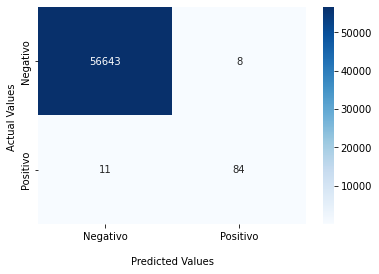

In [18]:
cf_matrix = [[56643, 8], [11, 84]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

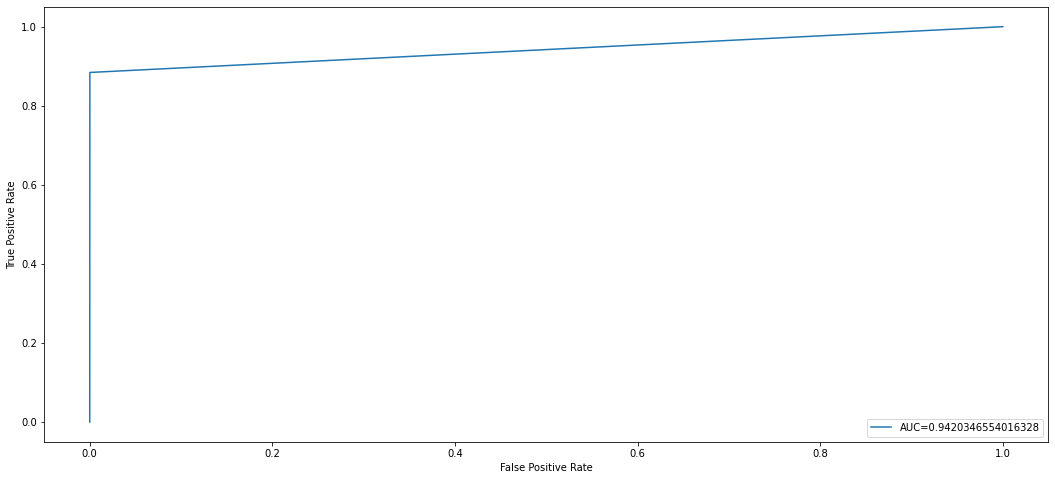

In [84]:
fpr, tpr, _ = roc_curve(y_test,  mplc_pred)
auc = roc_auc_score(y_test,   mplc_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Oversampled data

In [62]:
mplc_ada = MLPClassifier(activation= 'tanh',
                     alpha= 0.001,
                     hidden_layer_sizes= (200,),
                     learning_rate= 'adaptive',
                     max_iter= 1000,
                     solver= 'adam', random_state=42)
mplc_ada.fit(X_ada_train, y_ada_train)
mplc_ada_pred = mplc_ada.predict(X_test)

In [63]:
evaluate_model(y_test, mplc_ada_pred)

Recall  0.8737
Precision  0.6148
f1 score  0.7217
Accuracy  0.9989
FPR  0.00091790083140633
ROC_AUC  0.9364

Confusion Matrix:
  [[56599    52]
 [   12    83]]


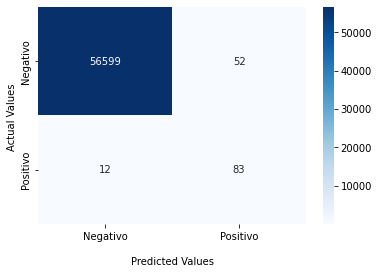

In [19]:
cf_matrix = [[56599, 52], [12, 83]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

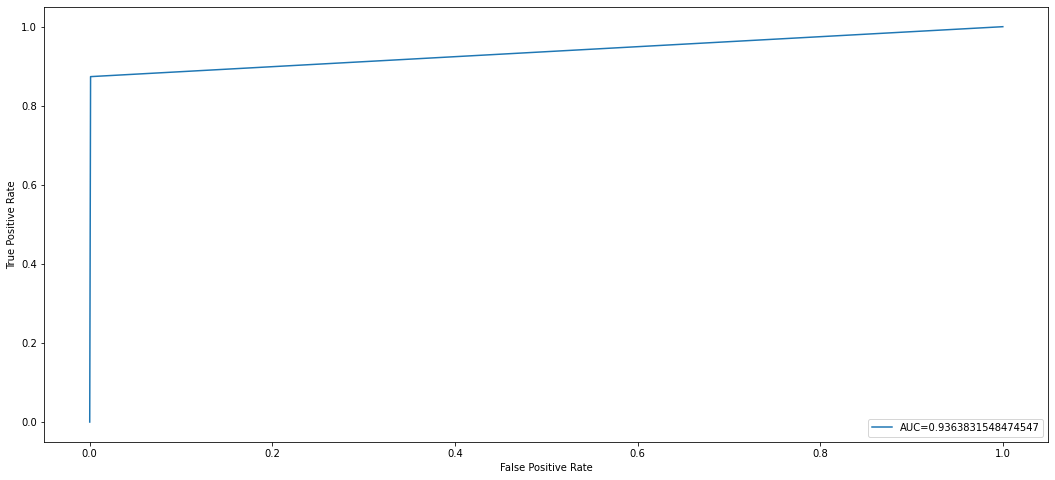

In [86]:
fpr, tpr, _ = roc_curve(y_test,  mplc_ada_pred)
auc = roc_auc_score(y_test,   mplc_ada_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Undersampled data

In [65]:
mplc_un = MLPClassifier(activation= 'tanh',
                     alpha= 0.001,
                     hidden_layer_sizes= (200,),
                     learning_rate= 'adaptive',
                     max_iter= 1000,
                     solver= 'adam', random_state=42)
mplc_un.fit(X_un_train, y_un_train)
mplc_un_pred = mplc_un.predict(X_test)

In [66]:
evaluate_model(y_test, mplc_un_pred)

Recall  0.9474
Precision  0.0261
f1 score  0.0508
Accuracy  0.9408
FPR  0.05922225556477379
ROC_AUC  0.9441

Confusion Matrix:
  [[53296  3355]
 [    5    90]]


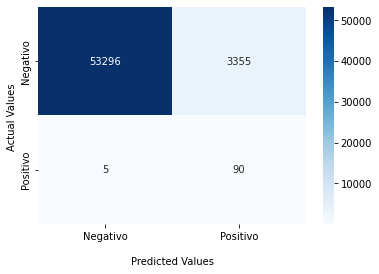

In [20]:
cf_matrix = [[53296, 3355], [5, 90]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.
plt.show()

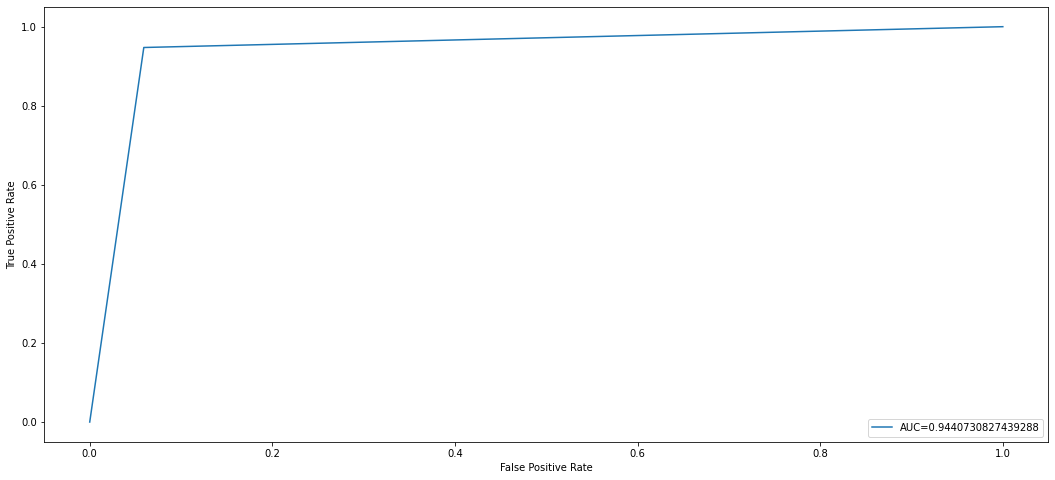

In [85]:
fpr, tpr, _ = roc_curve(y_test,  mplc_un_pred)
auc = roc_auc_score(y_test,   mplc_un_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Analizando las métricas y la matriz de confusión se puede observar una mejora en la sensibilidad del modelo con datos desbalanceados a los dos modelos con técnicas de undersampling. Sin embargo esto impacta negativamente en la precisión del modelo, reduciéndolo de un 91.3% al 2.61%. El modelo con técnicas de undersampling es además el modelo con una mayor puntuación AUC ROC y sensibilidad del 94.74%.

# **Conclusión**

En la mayoría de los modelos se observa una tendencia a mejorar la sensibilidad del modelo al aplicar técnicas de remuestreo, con la penalización de que empeora la precisión del modelo. A la hora de elegir el mejor modelo podríamos seguir diversos criterios. El modelo con una mayor sensibilidad, porcentaje de transacciones fraudulentas predichas como tal, es la Red Neuronal entrenada con técnicas de undersampling (94.7%) y el modelo con una mayor puntuación AUC ROC es el Random Forest entrenado con técnicas de undersampling (0.953 y una sensibilidad del 92.6%). La Red Neuronal tiene una sensibilidad 2.1% mayor, lo cual para nuestra aplicación se traduce en un mayor ahorro para la empresa, ya que es el modelo que predice correctamente un mayor porcentaje de fraudes.

A continuación, se exporta usando la librería de pickle el modelo seleccionado.

In [107]:
with open('mlpc_model.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(mplc_un, f, pickle.HIGHEST_PROTOCOL)